In [70]:
import tensorflow as tf
import numpy as np
import os
import re
import gc
from matplotlib import pyplot as plt

## Data Pipeline
We already have the dataset stored in compressed binary records in a gcloud bucket. Using the tf and gcloud apis, we can load these records directly into a dataset without having to use any auxiliary disk space on this notebook. I am trying out two methods here. The first is one emlpoyed by @hoyso48, the winner of the isolated hand sign competition. Idk how they were able to select significant coordinates (by hand?), but this mere fact made me skeptical that PCA would be more statistically robust.

For PCA, I perform incremental PCA on

In [3]:
DATA_DIR = './aslf-5fold-20230815-001950/'
DATASET_FILENAMES = list(map(lambda x: os.path.join(DATA_DIR, x), os.listdir(DATA_DIR)))

In [4]:
def decode_features(b):
    features = {
    'frame': tf.io.FixedLenFeature([], dtype=tf.string),
    'sequence': tf.io.FixedLenFeature([], dtype=tf.string)
    }
    decoded = tf.io.parse_single_example(b, features)
    decoded['frame'] = tf.reshape(tf.io.decode_raw(decoded['frame'], out_type=np.float32), (-1, ROWS_PER_FRAME, 3))
    decoded['sequence'] = tf.io.decode_raw(decoded['sequence'], out_type=np.int64)

    return decoded

In [5]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename.split('/')[-1]).group(1)) for filename in filenames]
    return sum(n)

In [6]:
## code copied from @hoyso48
ROWS_PER_FRAME = 543
MAX_FRAME_LEN = 384
MAX_SEQ_LEN = 30
NUM_CLASSES  = 59
PAD = -100.
NOSE=[
    1,2,98,327
]
LNOSE = [98]
RNOSE = [327]
LIP = [ 0,
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LLIP = [84,181,91,146,61,185,40,39,37,87,178,88,95,78,191,80,81,82]
RLIP = [314,405,321,375,291,409,270,269,267,317,402,318,324,308,415,310,311,312]

POSE = [500, 502, 504, 501, 503, 505, 512, 513]
LPOSE = [513,505,503,501]
RPOSE = [512,504,502,500]

REYE = [
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    246, 161, 160, 159, 158, 157, 173,
]
LEYE = [
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    466, 388, 387, 386, 385, 384, 398,
]

LHAND = np.arange(468, 489).tolist()
RHAND = np.arange(522, 543).tolist()

POINT_LANDMARKS = LIP + LHAND + RHAND + NOSE + REYE + LEYE #+POSE

NUM_NODES = len(POINT_LANDMARKS)
CHANNELS = 6*NUM_NODES

print(NUM_NODES)

# TODO: figure out why this is *
print(CHANNELS)

def interp1d_(x, target_len, method='random'):
    length = tf.shape(x)[1]
    target_len = tf.maximum(1,target_len)
    if method == 'random':
        if tf.random.uniform(()) < 0.33:
            x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bilinear')
    else:
        if tf.random.uniform(()) < 0.5:
            x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bicubic')
        else:
            x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'nearest')
    else:
        x = tf.image.resize(x, (target_len,tf.shape(x)[1]),method)
    return x

def tf_nan_mean(x, axis=0, keepdims=False):
      '''Compute the mean of a set of frames about an excluding the indices that are nan'''
      return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    '''Compute the std on an axis about a center excluding the indices that are nan'''
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))

class Preprocess(tf.keras.layers.Layer):
    '''Perform feature selection for frames, and normalization of the dataframe'''
    def __init__(self, max_len=MAX_SEQ_LEN, point_landmarks=POINT_LANDMARKS, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.point_landmarks = point_landmarks
    

    def call(self, inputs):
        # add a batch dimension to the inputs if it doesn't exist
        if tf.rank(inputs) == 3:
              x = inputs[None,...]
        else:
              x = inputs
        
        # find the mean about the nose (point 17) and interpolate to 0.5 where the mean cannot be calculated
        mean = tf_nan_mean(tf.gather(x, [17], axis=2), axis=[1,2], keepdims=True)
        mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
        
        # extract the point landmarks that we have explicitly specified
        x = tf.gather(x, self.point_landmarks, axis=2) #N,T,P,C
        std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)
        
        # normalize
        x = (x - mean)/std
        
        # truncate to max_len
        if self.max_len is not None:
            x = x[:,:self.max_len]
        length = tf.shape(x)[1]
        
        # discard z dim. Try without
        x = x[...,:2]
        
        # first and second order rates of change as features
        dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))
        dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]]),lambda:tf.zeros_like(x))
        
        # stack all features along axis 3 and then concat along axis 3
        x = tf.concat([
          tf.reshape(x, (-1,length,2*len(self.point_landmarks))),
          tf.reshape(dx, (-1,length,2*len(self.point_landmarks))),
          tf.reshape(dx2, (-1,length,2*len(self.point_landmarks))),
        ], axis = -1)
        
        # finally, sub zeros in nans
        x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)
        return x

118
708


<_MapDataset element_spec={'frame': TensorSpec(shape=(None, 543, 3), dtype=tf.float32, name=None), 'sequence': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>


2023-08-21 17:30:13.046099: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


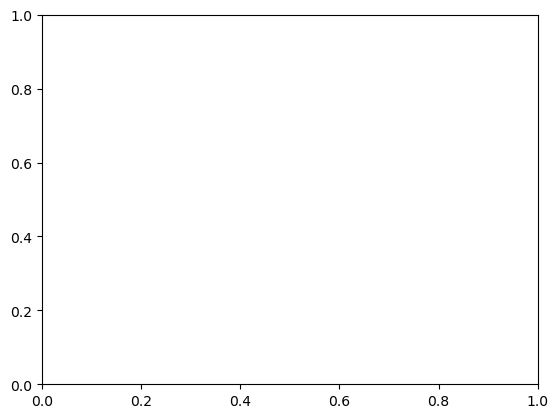

In [7]:
# little dataset visualizer
from IPython.display import HTML
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

def filter_nans(frames):
  '''Filter out all frames where all nan'''
  return frames[~np.isnan(frames).all(axis=(-2,-1))]


ds = tf.data.TFRecordDataset(DATASET_FILENAMES, compression_type='GZIP', name='aslf5folddataset', num_parallel_reads=tf.data.AUTOTUNE)
ds = ds.map(decode_features)
print(ds)


# find the first example where the left hand is visible
for x in ds:
    temp = x['frame'].numpy()
    if not len(filter_nans(temp[:,LHAND])) == 0:
        break

edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]

fig, ax = plt.subplots()

def plot_frame(frame, edges=[], idxs=[]):

    frame[np.isnan(frame)] = 0
    x = list(frame[...,0])
    y = list(frame[...,1])
    if len(idxs) == 0:
        idxs = list(range(len(x)))
    ax.clear()
    ax.scatter(x, y, color='dodgerblue')
    for i in range(len(x)):
        ax.text(x[i], y[i], idxs[i])

    for edge in edges:
        ax.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], color='salmon')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def animate_frames(frames, edges=[], idxs=[]):
    anim = FuncAnimation(fig, lambda frame: plot_frame(frame, edges, idxs), frames=frames, interval=100)
    return HTML(anim.to_jshtml())

In [8]:
# Left hand check
animate_frames(filter_nans(temp[:,LHAND]),edges=edges)

In [9]:
# PCA action
N_PCA = 100

from sklearn.decomposition import IncrementalPCA

class PCAPreprocess(tf.keras.layers.Layer):
  '''Preprocessing before feeding to incremental PCA'''
  def __init__(self, max_len=MAX_LEN, **kwargs):
    super().__init__(**kwargs)
    self.max_len = max_len

  def call(self, inputs):
    # add a batch dimension to the inputs if it doesn't exist
    if tf.rank(inputs) == 3:
      x = inputs[None,...]
    else:
      x = inputs

    # find the mean about the nose (point 17) and interpolate to 0.5 where the mean cannot be calculated
    mean = tf_nan_mean(tf.gather(x, [17], axis=2), axis=[1,2], keepdims=True)
    mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)

    # standardize
    std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)
    x = (x - mean)/std

    if self.max_len is not None:
      x = x[:,:self.max_len]
    length = tf.shape(x)[1]
    x = x[...,:2]

    # first and second order rates of change as features
    dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))
    dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]]),lambda:tf.zeros_like(x))

    # create a new axis for the derivative features
    x = tf.concat([
      tf.reshape(x, (-1,length,2*len(self.point_landmarks))),
      tf.reshape(dx, (-1,length,2*len(self.point_landmarks))),
      tf.reshape(dx2, (-1,length,2*len(self.point_landmarks))),
    ], axis = -1)

    # sub zeros in nans
    x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)
    # flatten along the feature, coordinate, and derivative features
    b, s, f, c, d = x.get_shape()
    x = tf.reshape(x, (b,s,f*c*d))
    return x

def do_ipca(ds, max_len=MAX_FRAME_LEN, n_components=N_PCA):
  preprocess = PCAPreprocess(max_len)
  ds = ds.map(lambda x: preprocess(x), tf.data.AUTOTUNE)

  pca = IncrementalPCA(n_components)
  pca.fit(ds)


class PCAApplication(tf.keras.layers.Layer):
  '''Apply PCA'''
  def __init__(self, pca, max_len=MAX_LEN, **kwargs):
    super().__init__(**kwargs)
    self.pca = pca
    self.max_len = max_len

  def call(self,inputs):
    if tf.rank(inputs) == 3:
      x = inputs[None,...]
    else:
      x = inputs

    x = pca()

NameError: name 'MAX_LEN' is not defined

In [ ]:
do_ipca(ds, max_len=MAX_LEN)

## Augmentation

Consider some of the following:
- Flips
- Rescalings
- random samples

# Data Pipeline Todos
- [x] come up with a more efficient encoding format to be read
- [x] Make sure that the data is not corrupted *before* you upload 60G of this to s3 lol

## Data Augmentation
Some operations performed to vary training data in ways that may generalize the training distributions based on the data that we currently have. Some operations that we perform:

- Flipping
- Random resampling
- Random affine transformation in space
- Temporal masking

In [10]:
def data_augmentation(x):
  '''Data augmentation collection. Apply each transformation with the following probabilities

  TODO: implement these transformations
  '''
  return x


def filter_nans_tf(x, ref_point=POINT_LANDMARKS):
  '''Apply the same operation as filter_nans for tensors'''
  mask = tf.math.logical_not(tf.reduce_all(tf.math.is_nan(tf.gather(x,ref_point,axis=1)), axis=[-2,-1]))
  x = tf.boolean_mask(x, mask, axis=0)
  return x

# TODO: see if we can get rid of the batch dimension in the preprocessing
def preprocess(example, feature_preprocessor: Preprocess, augment=False, max_frame_len=MAX_FRAME_LEN, max_seq_len=MAX_SEQ_LEN):
  '''Apply feature preprocessing to the feature, conditionally augment, return the resulting feature, label frame'''
  x = example['frame']
  x = filter_nans_tf(x)
  if augment:
    x = data_augmentation(x, max_frame_len)

  x = feature_preprocessor(x)[0]
  y = example['sequence'][:max_seq_len]

  return x, y, tf.shape(x)[0], len(y)


def get_data_set(file_list, batch_size, max_frame_len, max_seq_len, drop_remainder=False, augment=False, shuffle=False, repeat=False):
  ds = tf.data.TFRecordDataset(file_list, compression_type='GZIP', num_parallel_reads=tf.data.AUTOTUNE)
  ds = ds.map(decode_features, num_parallel_calls=tf.data.AUTOTUNE)
  feature_preprocessor = Preprocess(max_frame_len, POINT_LANDMARKS)
  ds = ds.map(lambda x: preprocess(x, feature_preprocessor, augment, max_frame_len), tf.data.AUTOTUNE)

  # repeats the dataset indefinitely
  if repeat:
    ds = ds.repeat()

  # shuffle the dataset with buffer size shuffle
  # when we shuffle we can disable deterministic loading
  if shuffle:
    ds = ds.shuffle(shuffle)
    options = tf.data.Options()
    options.deterministic = False
    ds = ds.with_options(options)

  if batch_size:
    ds = ds.padded_batch(batch_size, padding_values=(tf.constant(PAD, dtype=tf.float32), tf.constant(0, dtype=tf.int64), None, None), padded_shapes=([max_frame_len, CHANNELS],[max_seq_len], [], []), drop_remainder=drop_remainder)

  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

ds = get_data_set(DATASET_FILENAMES, 100, 100, 30, False, False, True, False)

for x in ds:
  display(x[0].shape)
  break

TensorShape([100, 100, 708])

## Model

In [11]:
class ECA(tf.keras.layers.Layer):
    '''An efficient channel attention mechanism as described in https://arxiv.org/abs/1910.03151'''
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.gp = tf.keras.layers.GlobalAveragePooling1D()
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False)
    
    def call(self, inputs, mask=None):
        nn = self.gp(inputs)
        nn = tf.expand_dims(nn, -1) # unsqueeze along last axis
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn
      


class LateDropout(tf.keras.layers.Layer):
    '''A dropout layer that applies after only start_step instances of training'''
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)

    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype='int64', aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda: inputs, lambda: self.dropout(inputs, training=training))
        if training:
            self._train_counter.assign_add(1)
        return x



class CausalDWConv1D(tf.keras.layers.Layer):
    '''Apply 1D convolution to the inputs with a causal padding. In cases with very low frame rates, this causal padding can become significant.'''
    def __init__(self,
                 kernel_size=17,
                 dilation_rate=1,
                 use_bias=False,
                 depthwise_initializer='glorot_uniform',
                 name='',
                 **kwargs):
      super().__init__(name=name, **kwargs)
      # we pad the input with zeros that allow the convolution filters to process the first kernel_size - 1 samples independently. This is why we call it a 'causal' filter.
      # we do this instead of using the
      self.padding = tf.keras.layers.ZeroPadding1D(padding=(dilation_rate*(kernel_size - 1), 0), name=name + '_pad')
      self.conv = tf.keras.layers.DepthwiseConv1D(kernel_size,
                                                  padding='valid',
                                                  depth_multiplier=1,
                                                  dilation_rate=dilation_rate,
                                                  use_bias=use_bias,
                                                  depthwise_initializer=depthwise_initializer,
                                                  name=name + '_dwconv')
      self.supports_masking = True

    def call(self, x):
      x = self.padding(x)
      x = self.conv(x)
      return x

def Conv1DBlock(channel_size,
                kernel_size=17,
                dilation_rate=1,
                drop_rate=0.0,
                expand_ratio=2,
                se_ratio=0.25,
                activation='swish',
                name=None):
      '''Efficient 1D convolution block @hoyso48'''
      if name == None:
        name = str(tf.keras.backend.get_uid('mbblock'))

      def apply(inputs):
          channels_in = tf.keras.backend.int_shape(inputs)[-1]
          channels_expand = channels_in * expand_ratio

          skip = inputs
          
          x = tf.keras.layers.Dense(
              channels_expand,
              use_bias=True,
              activation=activation,
              name=name + '_expand_conv')(inputs)

          x = CausalDWConv1D(kernel_size,
                             dilation_rate=dilation_rate,
                             use_bias=False,
                             name=name + '_dwconv')(x)
          x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)
          x = ECA()(x)
          
          x = tf.keras.layers.Dense(
              channel_size,
              use_bias=True,
              name=name + '_project_conv')(x)
          if drop_rate > 0:
              x = tf.keras.layers.Dropout(drop_rate,noise_shape=(None,1,1), name=name + '_drop')(x)
          if (channels_in == channel_size):
              x = tf.keras.layers.add([x, skip], name=name + '_add')
          return x
      return apply


In [41]:
def get_model(max_len=64, dropout_step=0, dim=192):
    inp = tf.keras.Input((max_len, CHANNELS))
    x = tf.keras.layers.Masking(mask_value=PAD, input_shape=(max_len,CHANNELS))(inp)
    ksize=17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim, ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim, ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim, ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim, ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim, ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim, ksize,drop_rate=0.2)(x)
    x = tf.keras.layers.Dense(dim*2, activation=None, name='top_conv')(x)
    x = LateDropout(0.8, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, name='classifier')(x)
    return tf.keras.Model(inp, x)    
model = get_model(384)

# for x in ds:
#     y = model(x[0])
#     print(y.shape)
#     break

class EditDistanceMetric(tf.keras.metrics.Metric):
    def __init__(
        self,
        normalize=True,
        dtype="float32",
        name="edit_distance",
        **kwargs,
    ):
        super().__init__(name=name, dtype=dtype, **kwargs)

        if dtype not in {'float32', 'float64'}:
            
            raise ValueError(
                "`dtype` must be a floating point type. "
                f"Received: dtype={dtype}"
            )

        self.normalize = normalize

        self._aggregate_unnormalized_edit_distance = self.add_weight(
            shape=(),
            initializer="zeros",
            dtype=self.dtype,
            name="aggregate_unnormalized_edit_distance",
        )
        
        if normalize:
            self._aggregate_reference_length = self.add_weight(
                shape=(),
                initializer="zeros",
                dtype=self.dtype,
                name="aggregate_reference_length",
            )
        else:
            self._number_of_samples = self.add_weight(
                shape=(),
                initializer="zeros",
                dtype=self.dtype,
                name="number_of_samples",
            )
    def update_state(self, y_true, y_pred, sample_weight=None):
        def validate_and_fix_rank(inputs, tensor_name):
            if not isinstance(inputs, (tf.Tensor, tf.RaggedTensor)):
                inputs = tf.ragged.constant(inputs)

            if inputs.shape.rank == 1:
                return tf.RaggedTensor.from_tensor(inputs[tf.newaxis])
            elif inputs.shape.rank == 2:
                return inputs
            else:
                raise ValueError(
                    f"{tensor_name} must be of rank 1 or 2. "
                    f"Found rank: {inputs.shape.rank}"
                )

        y_true = validate_and_fix_rank(y_true, "y_true")
        y_pred = validate_and_fix_rank(y_pred, "y_pred")

        if self.normalize:
            self._aggregate_reference_length.assign_add(
                tf.cast(tf.size(y_true.flat_values), dtype=self.dtype)
            )

        def calculate_edit_distance(args):
            reference, hypothesis = args

            reference = tf.sparse.from_dense([reference])
            hypothesis = tf.sparse.from_dense([hypothesis])

            edit_distance = tf.squeeze(
                tf.edit_distance(
                    hypothesis=hypothesis,
                    truth=reference,
                    normalize=False,
                )
            )

            self._aggregate_unnormalized_edit_distance.assign_add(
                tf.cast(edit_distance, dtype=self.dtype)
            )
            if not self.normalize:
                self._number_of_samples.assign_add(tf.cast(1, dtype=self.dtype))
            return 0

        _ = tf.map_fn(
            fn=calculate_edit_distance,
            elems=(y_true, y_pred),
            fn_output_signature="int8",
        )

    def result(self):
        if self.normalize:
            if self._aggregate_reference_length == 0:
                return 0.0
            return (
                self._aggregate_unnormalized_edit_distance
                / self._aggregate_reference_length
            )
        if self._number_of_samples == 0:
            return 0.0
        return (
            self._aggregate_unnormalized_edit_distance / self._number_of_samples
        )

    def reset_state(self):
        self._aggregate_unnormalized_edit_distance.assign(0.0)
        if self.normalize:
            self._aggregate_reference_length.assign(0.0)
        else:
            self._number_of_samples.assign(0.0)

    def get_config(self):
        config = super().get_config()
        config.update({"normalize": self.normalize})
        return config
        

class ASLFConvModel(tf.keras.Model):
    def __init__(self, max_len=64, dropout_step=0, dim=192, beam_width=20, **kwargs):
        super().__init__(**kwargs)
        self.functional_layers = get_model(max_len, dropout_step, dim)
        self.built = True
        self.beam_width = beam_width
        self.edit_dist = EditDistanceMetric(normalize=True)
        
    def train_step(self, example):
        X, y, X_len, y_len = example

        # keep track of all variables in computing teh loss with tf.GradientTape
        with tf.GradientTape() as tape:
            logits = self(X)
            logits = tf.transpose(logits, perm=[1, 0, 2])
            loss = tf.nn.ctc_loss(y, logits, y_len, X_len)

        # get trainable variables and compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # update wegihts
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # update metrics
        # Metrics are configured in `compile()`.
        
        return {'loss': tf.reduce_sum(loss)}
                
    def test_step(self, example):
        X, y, X_len, y_len = example
        batch_size, seq_len = y.shape
        
        logits = self(X)
        logits = tf.transpose(logits, [1, 0, 2])
        
        loss = tf.nn.ctc_loss(y, logits, y_len, X_len)
        paths, probs = tf.nn.ctc_beam_search_decoder(logits, X_len, beam_width=self.beam_width, top_paths=1)
        pred = paths[0]

        y = tf.RaggedTensor.from_tensor(y, y_len)
        pred = tf.RaggedTensor.from_sparse(pred)
        
        for metric in self.metrics:
            if metric.name == 'edit_distance':
                metric.update_state(y, pred)

        ret_metrics = {m.name: m.result() for m in self.metrics}
        ret_metrics['loss'] = tf.reduce_sum(loss)
        return ret_metrics

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.edit_dist]

    def call(self, X):
        return self.functional_layers(X)

## Model training and evaluation

In [13]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def get_strategy(device='TPU-VM'):
    if 'TPU' in device:
        tpu = 'local' if device == 'TPU-VM' else None
        print('connecting to TPU...')
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribut.TPUStrategy(tpu)
        IS_TPU = True

    if device == 'GPU' or device == 'CPU':
        ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
        if ngpu>1:
            print('Using multi GPU')
            strategy = tf.distribute.MirroredStrategy()
        elif ngpu==1:
            print('Using single GPU')
            strategy = tf.distribute.get_strategy()
        else:
            print('Using CPU')
            strategy = tf.distribute.get_strategy()
        IS_TPU = False

    if device == 'GPU':
        print('Num GPUs available: ', ngpu)

    REPLICAS = strategy.num_replicas_in_sync
    print('Replicas: ', REPLICAS)

    return strategy, REPLICAS, IS_TPU

STRATEGY, N_REPLICAS, IS_TPU = get_strategy('GPU')        

Using CPU
Num GPUs available:  0
Replicas:  1


In [86]:
class SubModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):
    def _save_model(self, epoch, batch, logs):
        """Saves the model.

        Args:
            epoch: the epoch this iteration is in.
            batch: the batch this iteration is in. `None` if the `save_freq`
              is set to `epoch`.
            logs: the `logs` dict passed in to `on_batch_end` or `on_epoch_end`.
        """
        logs = logs or {}

        if (
            isinstance(self.save_freq, int)
            or self.epochs_since_last_save >= self.period
        ):
            # Block only when saving interval is reached.
            self.epochs_since_last_save = 0
            filepath = self._get_file_path(epoch, batch, logs)

            # Create host directory if it doesn't exist.
            dirname = os.path.dirname(filepath)
            if dirname and not tf.io.gfile.exists(dirname):
                tf.io.gfile.makedirs(dirname)

            try:
                if self.save_best_only:
                    current = logs.get(self.monitor)
                    if current is None:
                        logging.warning(
                            "Can save best model only with %s available, "
                            "skipping.",
                            self.monitor,
                        )
                    else:
                        if self.monitor_op(current, self.best):
                            if self.verbose > 0:
                                io_utils.print_msg(
                                    f"\nEpoch {epoch + 1}: {self.monitor} "
                                    "improved "
                                    f"from {self.best:.5f} to {current:.5f}, "
                                    f"saving model to {filepath}"
                                )
                            self.best = current
                            if self.save_weights_only:
                                self.model.save_weights(
                                    filepath,
                                    overwrite=True,
                                    options=self._options,
                                )
                            else:
                                self.model.functional_layers.save(
                                    filepath,
                                    overwrite=True,
                                    options=self._options,
                                )
                        else:
                            if self.verbose > 0:
                                io_utils.print_msg(
                                    f"\nEpoch {epoch + 1}: "
                                    f"{self.monitor} did not improve "
                                    f"from {self.best:.5f}"
                                )
                else:
                    if self.verbose > 0:
                        io_utils.print_msg(
                            f"\nEpoch {epoch + 1}: saving model to {filepath}"
                        )
                    if self.save_weights_only:
                        self.model.save_weights(
                            filepath, overwrite=True, options=self._options
                        )
                    elif filepath.endswith(".keras"):
                        self.model.save(filepath, overwrite=True)
                    else:
                        self.model.save(
                            filepath, overwrite=True, options=self._options
                        )

                self._maybe_remove_file()
            except IsADirectoryError:  # h5py 3.x
                raise IOError(
                    "Please specify a non-directory filepath for "
                    "ModelCheckpoint. Filepath used is an existing "
                    f"directory: {filepath}"
                )
            except IOError as e:  # h5py 2.x
                # `e.errno` appears to be `None` so checking the content of
                # `e.args[0]`.
                if "is a directory" in str(e.args[0]).lower():
                    raise IOError(
                        "Please specify a non-directory filepath for "
                        "ModelCheckpoint. Filepath used is an existing "
                        f"directory: f{filepath}"
                    )
                # Re-throw the error for any other causes.
                raise e

def train_fold(CFG, fold, train_files, valid_files=None, strategy=STRATEGY, summary=True):
    """
    
    """
    tf.keras.backend.clear_session()
    gc.collect()
    tf.config.optimizer.set_jit(True)

    train_ds = get_data_set(train_files, batch_size=CFG.batch_size, max_frame_len=CFG.max_frame_len, max_seq_len=CFG.max_seq_len, drop_remainder=True, augment=CFG.augment, repeat=True)
    if valid_files:
        valid_ds = get_data_set(valid_files, batch_size=CFG.batch_size, max_frame_len=CFG.max_frame_len, max_seq_len=CFG.max_seq_len, drop_remainder=True, augment=CFG.augment, repeat=True)
    else:
        valid_files = []

    num_train = count_data_items(train_files)
    num_valid = count_data_items(valid_files)
    steps_per_epoch = num_train//CFG.batch_size
    with strategy.scope():
        dropout_step = CFG.dropout_start_epoch*steps_per_epoch
        model = ASLFConvModel(max_len=CFG.max_frame_len, dropout_step=dropout_step, dim=CFG.dim)
        schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=CFG.learning_rate, decay_steps=steps_per_epoch, decay_rate=0.95)
        opt = tf.keras.optimizers.Adam(learning_rate=schedule)
    
        model.compile(
            optimizer=opt,
            steps_per_execution=steps_per_epoch,
        )

    if summary:
        model.functional_layers.summary()
        print()
        print(train_ds, valid_ds)
        print()

    print(f'---------fold{fold}----------')
    print(f'train:{num_train} valid:{num_valid}')
    print()

    if CFG.resume:
        print('resume from epoch ', CFG.resume)
        model.load_weights(f'{CFG.output_dir}/{CFG.train_name}-fold{fold}-last.weights')
        if train_ds is not None:
            model.evaluate(train_ds.take(steps_per_epoch))
        if valid_ds is not None:
            model.evaluate(valid_ds)
            

                                
                            
    
    logger = tf.keras.callbacks.CSVLogger(f'{CFG.output_dir}/{CFG.train_name}-fold{fold}-logs.csv')
    checkpoint = SubModelCheckpoint(f'{CFG.output_dir}/{CFG.train_name}-fold{fold}-best.h5', monitor='val_loss', verbose=0, save_best_only=True)
    callbacks = []
    if CFG.save_output:
        callbacks.append(logger)
        if fold != 'all':
            callbacks.append(checkpoint)

    history = model.fit(
        train_ds,
        epochs=CFG.epoch-CFG.resume,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        validation_data=valid_ds,
        verbose=CFG.verbose,
        validation_steps=num_valid//CFG.batch_size
    )

    if CFG.save_output:
        try:
            model.load_weights(f'{CFG.output_dir}/{CFG.train_name}-fold{fold}-best.h5')
        except:
            pass
    if fold != 'all':
        cv = model.evaluate(valid_ds, verbose=CFG.verbose, steps=num_valid//CFG.batch_size)
    else:
        cv = None
    
    return model, cv, history
        

def train_folds(CFG, folds, strategy=STRATEGY, summary=True):
    """Run training across folds. Setting a fold to 'all' will train for an epoch on the entire dataset"""
    for fold in folds:
        if fold != 'all':
            all_files = DATASET_FILENAMES
            train_files = [x for x in all_files if f'fold{fold}' not in x]
            valid_files = [x for x in all_files if f'fold{fold}' in x]
        else:
            train_files = DATASET_FILENAMES
            valid_files = None

        train_fold(CFG, fold, train_files, valid_files, strategy=strategy, summary=summary)

In [87]:
class CFG:
    save_output = True
    output_dir = './saves/'

    seed = 42
    verbose = 2 #0) silent 1) progress bar 2) one line per epoch

    max_frame_len = 384
    max_seq_len = 30
    replicas = N_REPLICAS
    learning_rate = 5e-4*replicas
    lr_min = 1e-6
    epoch = 1
    warmup = 0
    resume = 0
    batch_size = 64 * replicas
    augment = False
    dropout_start_epoch = 0
    dim = 192

    train_name = f'aslf-fp32-192-8-seed{seed}'

In [88]:
train_folds(CFG, [0])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 708)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 384, 708)     0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Dense)              (None, 384, 192)     135936      ['masking[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 384, 192)     768         ['stem_conv[0][0]']              
                                                                                              

16/16 - 56s - loss: 8318.2041 - val_edit_distance: 0.9447 - val_loss: 7074.4883 - 56s/epoch - 4s/step
40/40 - 36s - edit_distance: 0.9447 - loss: 7074.4883 - 36s/epoch - 903ms/step


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## Inference and TFLite Build

In [114]:
class InfPreprocess(tf.keras.layers.Layer):
    '''Perform feature selection for frames, and normalization of the dataframe'''
    def __init__(self, max_len=MAX_SEQ_LEN, point_landmarks=POINT_LANDMARKS, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.point_landmarks = point_landmarks
        self.permute = np.arange(0, 543*3)
    

    def call(self, inputs):
        # add a batch dimension to the inputs if it doesn't exist
        if tf.rank(inputs) == 2:
              x = inputs[None,...]
        else:
              x = inputs

        # permute and then reshape to working format
        x = tf.reshape(tf.gather(x, self.permute, axis=-1), (1, -1, 543, 3))
        
        # find the mean about the nose (point 17) and interpolate to 0.5 where the mean cannot be calculated
        mean = tf_nan_mean(tf.gather(x, [17], axis=2), axis=[1,2], keepdims=True)
        mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
        
        # extract the point landmarks that we have explicitly specified
        x = tf.gather(x, self.point_landmarks, axis=2) #N,T,P,C
        std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)
        
        # normalize
        x = (x - mean)/std
        
        # truncate to max_len
        if self.max_len is not None:
            x = x[:,:self.max_len]
        length = tf.shape(x)[1]
        
        # discard z dim. Try without
        x = x[...,:2]
        
        # first and second order rates of change as features
        dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))
        dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]]),lambda:tf.zeros_like(x))
        
        # stack all features along axis 3 and then concat along axis 3
        x = tf.concat([
          tf.reshape(x, (-1,length,2*len(self.point_landmarks))),
          tf.reshape(dx, (-1,length,2*len(self.point_landmarks))),
          tf.reshape(dx2, (-1,length,2*len(self.point_landmarks))),
        ], axis = -1)
        
        # finally, sub zeros in nans
        x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)
        return x

class TFLiteModel(tf.Module):
    """
    TensorFlow Lite model that takes input tensors and applies the preprocessing steps and then the ASLF model
    """
    def __init__(self, weights_file, beam_width, CFG):
        """
        Initialize the 
        """
        super().__init__()
        self.prep_inputs = InfPreprocess()
        self.beam_width = beam_width
        self.model = get_model(CFG.max_frame_len, dim=CFG.dim)
        self.model.load_weights(weights_file)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543*3], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        """
        Applies the preprocessor and an ensemble of models to the inputs, selecting the most confident output
        """
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
        x = self.model(x)
        

        # ctc beam decode
        # outputs = tf.nn.ctc_beam_search_decoder(x, tf.shape(x), self.beam_width)
        return x

tflite_model = TFLiteModel('./saves/aslf-fp32-192-8-seed42-fold0-best.h5', 20, CFG)

x = tflite_model(tf.random.normal((100, 543*3)))



In [115]:
x.shape

TensorShape([1, 30, 59])